## Learning Representations by Recirculation

Recirculation algorithms are a class of learning algorithms that use locality in time in their local learning rules as one example of a broader theme of how time may be used in *physical neural systems*. The key idea behind it is to trade off space for time, using differences in the activations of the same units at different times to drive the learning. Thus, in general, learning rules are typically polynomial in the local variables, the product of a presynaptic and a postsynaptic term (simple Hebbian rule), and where the postsynaptic term may be a difference between two activations taken over a relatively short time window.

Recirculation algorithms can be applied to the circular autoencoders. In the architecture of a circular autoencoder, the output units are identical (or spatially very close) to the input units. Therefore, recirculation algorithms recirculate information, i.e., propagate information, through the circular autoencoder over more than one full cycle and use information from different cycles to update the weights. Typically, earlier cycles are used as targets for later cycles, as information degrades with recirculation [Baldi, P. (2021). Deep Learning in Science. Cambridge: Cambridge University Press].




#### Python implementation of Hinton's recirculation algorithm for training autoencoders
<br>
The following code is a Python implementation of Hinton's recirculation algorithm for the circular autoencoders in [Hinton, Geoffrey E., and James McClelland, "Learning representations by recirculation." Neural Information Processing Systems, 1987]
<br>

In the code, the output of the circular autoencoder is recirculated to the other layers. We will focus primarily on the first two cycles indexed by t = 0 and t = 1. It is also possible to recirculate output information over multiple cycles.
The following drawing shows the assigned variables to weights (i.e., W), states (i.e., y), time (i.e., t), and place (i.e., p) are being shown while states of the visible and hidden units exploded in time and place. y is a variable for states in which the first dimension of y keeps the place order (i.e., two layers) and the second dimension keeps the time order (two cycles).

In the class of ReCrcl, the method of recrcl_passes perfrom two passes and weight updates. In the first pass, the original visible vector is passed around the loop. In the second pass, an average of the original vector and the reconstructed vector is passed around the loop. For updating weights, weights are updated by an amount proportional to the product of the "presynaptic" activity and the difference in the post-synaptic activity on the two passes. Finally, the method returns the reconstruction error, which is the difference between the original and the reconstructed visible vectors. The other function in this class, called encode_pass, returns the hidden code for the particular layer and the reconstructed output.
<br>
<br>

<img src="./ab.png" style="width:600px;"/>

In [2]:
# adding required libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

In [3]:
# Building recirculation class
class ReCrcl:
    def __init__(self, num_nrns, actv_fncs, lamda , eps ):
        
        self.num_nrns_ = np.array(num_nrns)
        self.actv_fncs_=np.array(actv_fncs)
        self.num_lyrs_ = len(self.num_nrns_)
        self.lamda_ = np.array(lamda)
        self.eps_=np.array(eps)
        # weight initialization with small random values uniformly distributed in the range of -0.5 to +0.5.
        self.wghts_ = []       
        for i in range(self.num_lyrs_):
            self.wghts_.append(np.random.random((self.num_nrns_[i] + 1, self.num_nrns_[(i+1)%(self.num_lyrs_)])) - 0.5)
              
    def recrcl_passes(self, inpts):
        # the first dimention of y keeps the place order (i.e. two layers) and 
        # the second dimention keep the time order (two time slots for each layer)
        y = []
        for i in self.num_nrns_:
            y.append(np.ones((2, inpts.shape[0], i + 1)))
        
        # First pass:original visible vector is passed around the loop
        y[0][0,:, :-1] = inpts
        for i in range(self.num_lyrs_ - 1):
            y[i+1][0, :, :-1] = self.actv_fncs_[i](y[i][0,:,  :] @ self.wghts_[i])
            
        # Second pass: an average of the original vector and the reconstructed vector is passed around the loop
        y[0][1, :, :-1] = self.lamda_[0] * y[0][0, :, :-1]+(1 - self.lamda_[0]) * self.actv_fncs_[-1](y[-1][0, :, :] @ self.wghts_[-1])
        for i in range(1, self.num_lyrs_):
            y[i][1, :, :-1] = self.lamda_[i] * y[i][0, :, :-1] + \
                              (1 - self.lamda_[i]) * self.actv_fncs_[i-1](y[i-1][ 1, :, :] @ self.wghts_[i-1])
            
        # Updating Weights: weights are updated by an amount proportional 
        # to the product of the "presynaptic" activity and the difference in the post-synaptic activity on the two passes
        for i in range(len(self.wghts_)-1):
            self.wghts_[i] += self.eps_[i] * y[i][1, :, :].T @ (y[i+1][0, :, :-1] - y[(i+1)%(self.num_lyrs_)][1, :, :-1])
        self.wghts_[-1] += self.eps_[-1] * y[-1][0, :, :].T @ (y[0][0, :, :-1] - y[0][1, :, :-1])
        
        # Return reconstruction error: difference between the original and the reconstructed visible vectors
        return 0.5 * ((inpts - y[0][1, :, :-1]) ** 2).sum()
    
    def inference_encode(self, inpts, lyr):
        y = []
        for i in self.num_nrns_:
            y.append(np.ones((inpts.shape[0], i + 1)))       
        y[0][:, :-1] = inpts  # input in
        for i in range(self.num_lyrs_ -1):
            # obtain hidden codes 
            y[(i+1)%(self.num_lyrs_)][:, :-1] = self.actv_fncs_[i](y[i][:, :] @ self.wghts_[i])          
        # Return the hidden code for the particular layer and the reconstructed output
        return y[lyr][:, :-1], self.actv_fncs_[-1](y[-1][:, :] @ self.wghts_[-1])
    

In [4]:
# Defining different smooth monotonic functions with bounded derivatives as activation functions
def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def logistic(x):
    return 1 / (1 + np.exp(-x))

In [17]:
recirculation = ReCrcl(num_nrns=[4, 2], actv_fncs=[logistic,logistic], lamda=[0.75,0.75], eps=[20,20]) # class instantiation

# loading inputs
inpts = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

# obtaining reconstruction errors on the 100 simulations
err=[]
for i in range(100):
    err.append(recirculation.recrcl_passes(inpts))

In [18]:
# extract codes in the hidden and output layers
hdn_encode, rcn_out = recirculation.inference_encode(inpts, lyr=1)

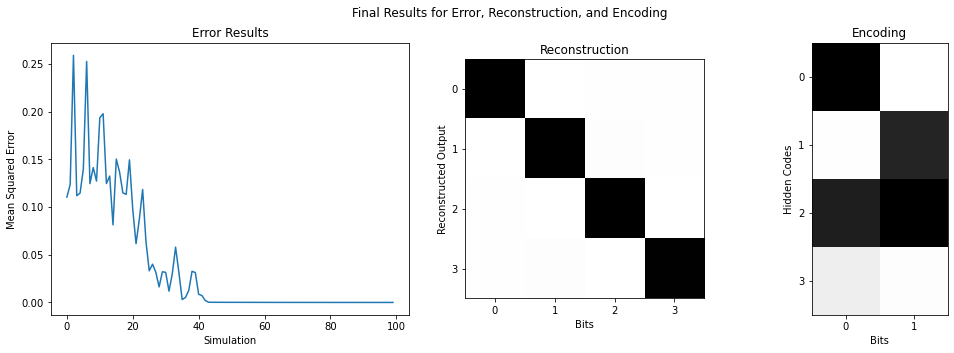

In [19]:
# Visualizing the results
fig = plt.figure(figsize=(17,5))
fig.suptitle('Final Results for Error, Reconstruction, and Encoding')
axes = fig.subplots(1, 3, gridspec_kw={'width_ratios': [1.5, 1,1]})
axes[0].plot(err)
axes[0].set_title('Error Results')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_xlabel('Simulation')
axes[1].imshow(rcn_out,cmap=plt.cm.binary)
axes[1].set_title('Reconstruction')
axes[1].set_ylabel('Reconstructed Output')
axes[1].set_xlabel('Bits')
axes[1].set_xticks([0, 1, 2, 3])
axes[1].set_yticks([0, 1, 2, 3])
axes[2].imshow(hdn_encode,cmap=plt.cm.binary)
axes[2].set_title('Encoding')
axes[2].set_ylabel('Hidden Codes')
axes[2].set_xlabel('Bits')
axes[2].set_yticks([0, 1, 2, 3])
axes[2].set_xticks([0, 1])
plt.show()